Some testing code for our inference and metrics functions. We'll assume inferences have already been drawn, and work with directories from the following locations,

* images: `/datadrive/snake/lakes/le7-2015/splits/train/images`
* labels: `/datadrive/snake/lakes/le7-2015/splits/train/labels`
* vector labels: `/datadrive/snakes/lakes/GL_3basins_2015.shp`
* predictions: `/datadrive/snake/lakes/le7-2015/inference`

In [1]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
from pathlib import Path

In [2]:
image_dir = Path("/datadrive/snake/lakes/le7-2015/splits/train/images/")
label_dir = Path("/datadrive/snake/lakes/le7-2015/splits/train/labels/")
pred_dir = Path("/datadrive/snake/lakes/le7-2015/inference")
vector_label = gpd.read_file("/datadrive/snake/lakes/GL_3basins_2015.shp")

Let's lookup the image and predictions corresponding to `GL083549E28854N-20150801`, the August 2015 prediction for lake `GL083549E28854N`.

In [3]:
sample_id = "GL086304E28374N-20150801"
x = rasterio.open(image_dir / f"{sample_id}.tif")
y = rasterio.open(label_dir / f"{sample_id}-labels.tif")
y_hat = rasterio.open(pred_dir / f"{sample_id}-pred.tif")

In [4]:
def plot_raster(z, delta = 1.5, ch=[0, 1, 2]):
    z = np.transpose(z, (1, 2, 0))[:, :, ch]
    plt.imshow(delta * z / np.nanmax(z))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


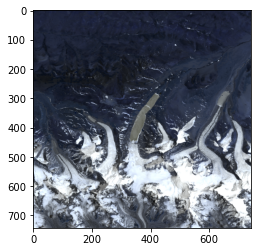

In [5]:
plot_raster(x.read())

It's actually hard to tell where the lake is, since we're so far zoomed out. Let's use the vector label to zoom into the actual lake.

In [6]:
vector_label = vector_label.set_index("GL_ID")
buffer = vector_label.buffer(distance=0.01)

gl_id = sample_id.split("-")[0]
v = buffer.loc[gl_id]

/tmp/ipykernel_80797/829974969.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffer = vector_label.buffer(distance=0.01)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


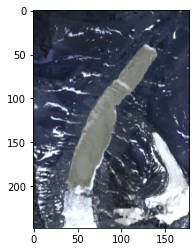

In [7]:
import rasterio.mask as rm

_, _, window = rm.raster_geometry_mask(x, [v], crop=True)
x_sub = x.read(window=window)
plot_raster(x_sub)

We can compare the true label with the predictions. Using our earlier code, we can compute metrics like IoU, precision, etc. Note that we will want to extract masks and smooth results somewhat (to remove tiny pixels from being classified as lakes).

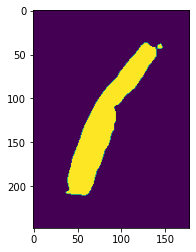

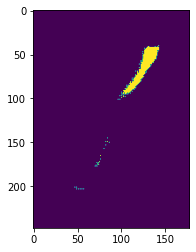

In [8]:
y_sub = y.read(window=window)
plot_raster(y_sub, ch=[0])
plt.show()

y_hat_sub = y_hat.read(window=window)
plot_raster(y_hat_sub, ch=[0])

An alternative idea is to build all the features directly and then crop them down to a buffer of the true lake of interest. Below, the truth is in blue, while the prediction is in purple.

<AxesSubplot:>

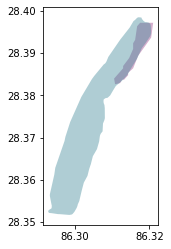

In [9]:
import sys
sys.path.append("..")
import utils.model_utils as mu

y_hat_poly = mu.polygonize_preds(y_hat, buffer.loc[gl_id])
base = y_hat_poly.plot(color="#953784", alpha=0.4)
vector_label.loc[gl_id:gl_id].plot(ax=base, color="#378495", alpha=0.4)

Once we have these polygons, we want to make sure we can run our usual metrics against the truth. For this, we need to maks both the truth and the predicted polygon, in a way that reflects the actual size of the lakes. We will compute metrics per each lake, and then can normalize by using a 

In [10]:
import utils.metrics as mt

y_poly = vector_label.loc[gl_id:gl_id]
metrics = {"IoU": mt.IoU, "precision": mt.precision, "recall": mt.recall}
mu.polygon_metrics(y_hat_poly, y_poly, y, metrics=metrics)

{'IoU': 0.10692798346281052,
 'precision': 0.910743772983551,
 'recall': 0.10806040465831757}